# Lingering Questions:

- Is there any intuitive reason as to why average gradient at large scales is not 1.5?
- Unclear exactly what wording in 2d means about find the something and the argument of a function F

In [169]:
# Python 3.10.6
# Run static type checking with `nbqa mypy oslo.ipynb`
# Run code formatting with `nbqa autopep8 --in-place oslo.ipynb`

import random
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
from time import sleep
from IPython.display import clear_output  # type: ignore

In [3]:
class Model:
    def __init__(self, length: int) -> None:
        """
        Initialise a new Oslo model of a given length
        """
        # min length of 3
        if length < 3:
            raise Exception("Min length is 3")
        self.length: int = length
        # the number of grains at a given location
        self.heights: list[int] = [0] * length
        # the gradient at a given location
        self.gradients: list[int] = [0] * length
        # generate an empty thresholds list
        self.thresholds: list[int] = [0] * length
        # record that the system is in the transient state
        self.is_transient: bool = True
        # randomise each of the new threshold values
        for i in range(length):
            self.new_threshold(i)
        # set plotting interactive mode on
        plt.ion()

    def get_length(self) -> int:
        return self.length

    def get_heights(self) -> list[int]:
        return self.heights

    def get_gradients(self) -> list[int]:
        return self.gradients

    def get_thresholds(self) -> list[int]:
        return self.thresholds

    def get_pile_height(self) -> int:
        return self.heights[0]

    def get_is_transient(self) -> bool:
        return self.is_transient

    def check_index_in_range(self, i: int) -> None:
        """
        Check the index is within the range of the model.
        If not, raise an exception
        """
        # note z_1 has index 0, z_l has index L-1
        if i >= self.length:
            raise Exception("Index out of range")

    def new_threshold(self, i: int) -> None:
        """
        Set a new threshold at position `i`.
        The threshold will be either 1 or 2 with equal chance.
        """
        self.check_index_in_range(i)
        self.thresholds[i] = random.randint(1, 2)

    def drive(self) -> None:
        """
        Add a single grain to the first position
        """
        self.heights[0] += 1
        self.gradients[0] += 1

    def is_supercritical(self, i: int) -> bool:
        """
        Return whether position `i`` is above the threshold
        """
        self.check_index_in_range(i)
        return self.gradients[i] > self.thresholds[i]

    def relax(self, i: int) -> None:
        """
        Relax the  site `i`, assuming it is above the threshold
        """
        self.check_index_in_range(i)
        if i == 0:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i+1] += 1
        elif i == self.length - 1:
            # end relaxation marks the transition to steady state
            if self.is_transient:
                self.is_transient = False
            self.heights[i] -= 1
            self.gradients[i] -= 1
            self.gradients[i-1] += 1
        else:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i-1] += 1
            self.gradients[i+1] += 1

        # ensure no values are below zero
        if self.heights[i] < 0:
            self.heights[i] = 0
        if self.gradients[i] < 0:
            self.gradients[i] = 0

        self.new_threshold(i)

    def cycle(self) -> None:
        """
        Perform one system cycle of driving and relaxation.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1

    def plot(self, sleep_amount=0, clear_screen=True) -> None:
        """
        Show the current state of the system in a graphic
        """
        sleep(sleep_amount)
        if clear_screen:
            clear_output()
        f = plt.figure()
        f.set_figwidth(3)
        f.set_figheight(6)
        plt.bar(np.array(range(self.length)) + 1, self.heights)
        plt.axis('scaled')
        plt.yticks(range(self.length * 2))
        plt.xticks(np.array(range(self.length)) + 1)
        plt.grid(axis='y')
        plt.show()

### Testing the basic plotting function

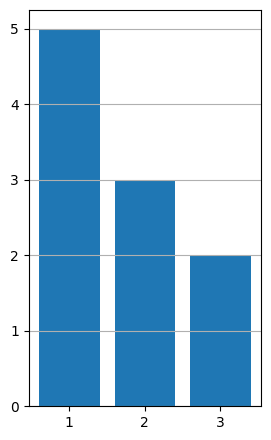

In [84]:
sleep_amount = 0.1

test_model = Model(3)

for i in range(100):
    test_model.plot(sleep_amount)
    test_model.cycle()

### Testing the logic

In [132]:
# measuring transient phase for L16
test_model = Model(16)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

202


In [136]:
# measuring transient phase for L32
test_model = Model(32)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

815


In [126]:
# L16 model should have average height of 26.5

final_heights = []

for i in range(50):
    test_model = Model(16)
    # get to steady state
    while test_model.get_is_transient():
        test_model.cycle()
    # once in steady state run for a set number of trials
    for i in range(1000):
        test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print(np.average(final_heights))

26.52


In [137]:
# L32 model should have average height of 53.9

final_heights = []

for i in range(50):
    test_model = Model(32)
    # get to steady state
    while test_model.get_is_transient():
        test_model.cycle()
    # once in steady state run for a set number of trials
    for i in range(1000):
        test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print(np.average(final_heights))

53.9


### 2a) Height of the Pile

In [138]:
# measuring transient phase for L256, seems to be 50-60k cycles
test_model = Model(256)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

56018


In [143]:
heights: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
number_cycles = 80000

In [158]:
for length in lengths:
    output: list[int] = []
    model = Model(length)
    for i in range(number_cycles):
        model.cycle()
        output.append(model.get_pile_height())
    heights.append(output)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


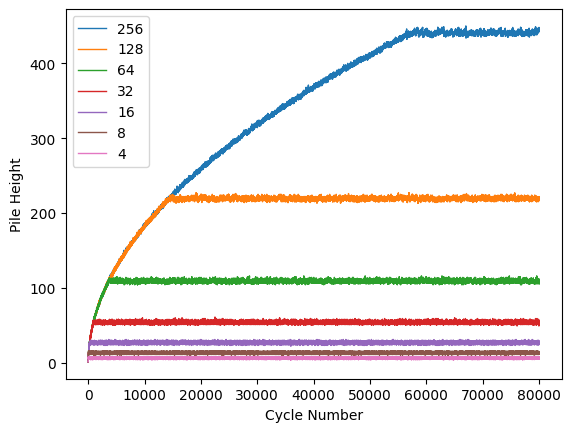

In [181]:
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.show()

### 2b) Cross Over Times

In [5]:
cross_over_times = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 20

In [6]:
for length in lengths:
    times = []
    for i in range(repetitions):
        model = Model(length)
        counter = 0
        while model.get_is_transient():
            model.cycle()
            counter += 1
        times.append(counter)
    cross_over_times.append(np.average(times))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


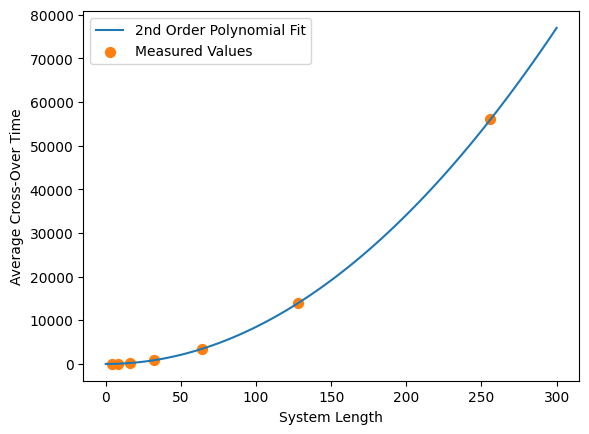

In [8]:
poly_fit = np.polyfit(lengths, cross_over_times, 2)
fit_x_vals = np.linspace(0, 300, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='2nd Order Polynomial Fit')

plt.scatter(lengths, cross_over_times, s=50,
            marker="o", c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Cross-Over Time")
plt.show()

### 2c) Scaling Arguments

For a system length far larger than 1, there will be some consistent value for the average gradient. This is not necessarily the average of the two possible threshold gradients since a gradient can be changed by grains falling onto it, grains leaving it as well as the critical threshold value.

In [32]:
averages = []

for i in range(100):
    model = Model(64)
    while model.is_transient:
        model.cycle()
    for i in range(10000):
        model.cycle
    averages.append(np.average(model.gradients))

print(np.average(averages))

1.6428125


Empirically the average value is found to be about 1.64, however all that matters is that this average gradient is scale independent on large scales. Given a set gradient, this gives large systems beyond the cross over point a triangular form, with angles that do not change with scale for all sufficiently large numbers. 

This gives the height of the triangle to be directly proportional to the base of the triangle, i.e. the length of the system. Similarly, cross over time corresponds to the area of the triangle, and thus cross over time should scale with square of the system length.

### 2d) Data Collapse of Average Height Scaling

Confused about what it's asking us to do here. Data already collapses onto a straight line for steady state, so unsure what the "function", "something" and "argument" are, and thus not sure what to do for evaluating the function as the argument gets very large and very small. 

In [49]:
average_heights = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 20

In [50]:
for length in lengths:
    height_values: list[int] = []
    for i in range(repetitions):
        model = Model(length)
        while model.get_is_transient():
            model.cycle()
        for i in range(5000):
            model.cycle()
        height_values.append(model.get_pile_height())
    average_heights.append(np.average(height_values))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


In [52]:
average_heights

[6.25, 12.95, 26.5, 53.75, 108.6, 218.8, 440.0]

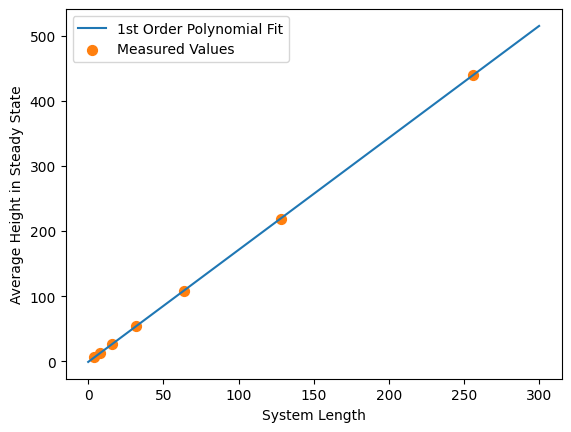

In [56]:
poly_fit = np.polyfit(lengths, average_heights, 1)
fit_x_vals = np.linspace(0, 300, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='1st Order Polynomial Fit')

plt.scatter(lengths, average_heights, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

#### Height scaling during the transient

This is predicted to be proportional to time to the power 1/2, since time corresponds to area, and height scales with the square root of area.

In [148]:
average_height_sequences = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 5

In [149]:
# a function to average lists of different lengths
# all lists are truncated to the shortest length

def average_different_lengths(a: list[list[int]]) -> list[int]:
    list_lengths = [len(i) for i in a]
    min_length = min(list_lengths)
    for l in a:
        while len(l) > min_length:
            l.pop(-1)
    return list(np.average(a, axis=0))

In [150]:
for length in lengths:
    heights = []
    for i in range(repetitions):
        model = Model(length)
        values = []
        while model.get_is_transient():
            model.cycle()
            values.append(model.get_pile_height())
        heights.append(values)
    average_height_sequences.append(average_different_lengths(heights))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


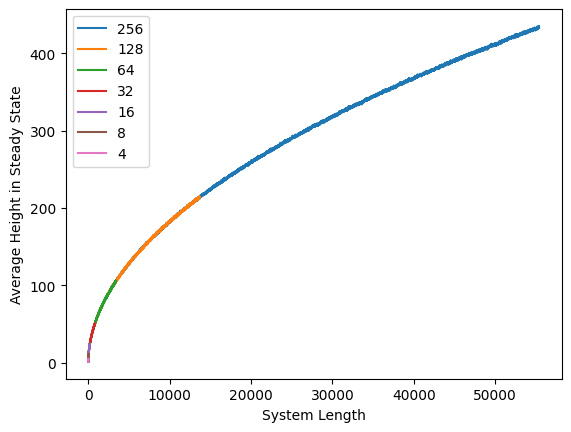

In [153]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

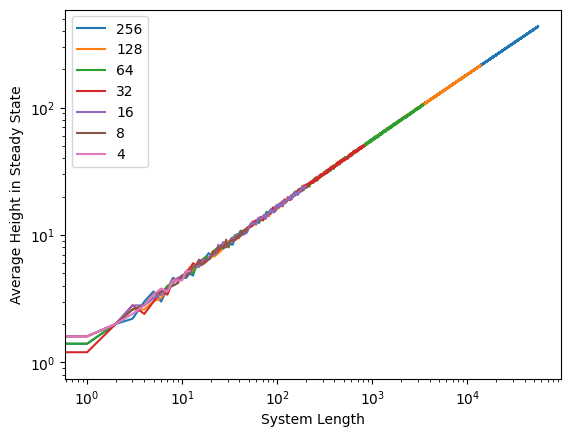

In [157]:
# log-log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

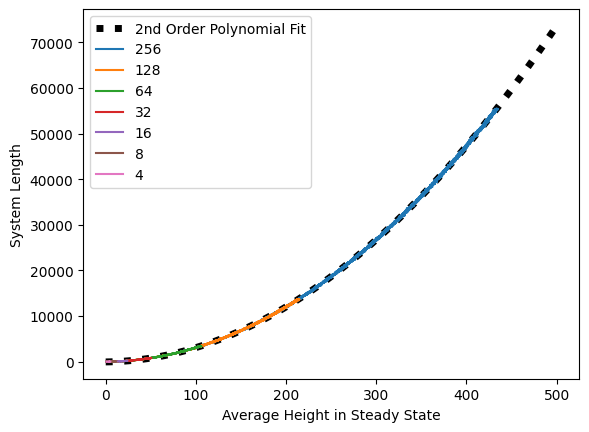

In [168]:
# if following a power law to the 1/2, then flipping the axis will follow a second order polynomial fit

# fitting the 256 data
poly_fit = np.polyfit(
    average_height_sequences[-1], range(len(average_height_sequences[-1])), 2)
fit_x_vals = np.linspace(0, 500, 100)
fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
plt.plot(fit_x_vals, fit_y_vals, label='2nd Order Polynomial Fit',
         linestyle='dotted', c='k', linewidth=5)

# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(average_height_sequences[i], range(
        len(average_height_sequences[i])), label=str(lengths[i]))
plt.legend()
plt.xlabel("Average Height in Steady State")
plt.ylabel("System Length")
plt.show()